<a href="https://colab.research.google.com/github/PMDixit/handGesture/blob/main/IndianResnet970.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets mediapipe --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 26.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import opendatasets as od
%matplotlib inline
import cv2
import mediapipe as mp
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow

matplotlib.rcParams['figure.facecolor'] = '#ffffff'#to keep background white

In [ ]:
project_name='indian-sign-language'

In [ ]:
dataset_url = "https://www.kaggle.com/vaishnaviasonawane/indian-sign-language-dataset"
dataset_url = "https://www.kaggle.com/saurabh24999/indian-sign-language"
dataset_url="https://www.kaggle.com/datasets/kapillondhe/american-sign-language"
dataset_url="https://www.kaggle.com/datasets/satwikpasumarthi/indian-sign-language-recognition"
#dataset_url="https://www.kaggle.com/datasets/sujatakukreti/indian-sign-language-dataset-2022"
#prajwalmdixit
#6960242e59b78799065573dee90d4200
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: prajwalmdixit
Your Kaggle Key: ··········


100%|██████████| 33.9M/33.9M [00:00<00:00, 68.1MB/s]


In [ ]:
# Look into the data directory
# Change the directory as required
data_dir = '/content/indian-sign-language-recognition/data1/train/'
classes = os.listdir(data_dir)
print(classes)
# import shutil
# shutil.rmtree("/content/indian-sign-language-recognition")

['3', 'W', 'K', 'U', 'E', 'A', 'L', '9', 'C', 'F', 'D', 'J', 'B', '4', 'M', 'T', '8', '7', '0', 'H', 'Z', 'P', 'S', 'O', 'Q', 'G', '6', 'V', 'X', '1', '5', '2', 'I', 'R', 'N', 'Y']


In [ ]:

for i in classes:
    IMAGE_FILES = os.listdir("/content/indian-sign-language-recognition/data1/test/"+i)
    for idx, file in enumerate(IMAGE_FILES):
      img=cv2.imread("/content/indian-sign-language-recognition/data1/test/"+i+"/"+file)
      cv2.imwrite('/content/indian-sign-language-recognition/data1/train/'+i+"/"+ str(idx+60)+'.jpg', img)

In [ ]:
A_file=os.listdir(data_dir+"A")
print("NO. of Training examples for A:",len(A_file))
print(A_file[:5])

NO. of Training examples for A: 70
['18.jpg', '33.jpg', '68.jpg', '40.jpg', '24.jpg']


In [ ]:
di={}
for i in classes:
    di[i]=len(os.listdir(data_dir+i))
print(di)

{'3': 70, 'W': 56, 'K': 70, 'U': 72, 'E': 70, 'A': 70, 'L': 71, '9': 73, 'C': 69, 'F': 72, 'D': 72, 'J': 71, 'B': 70, '4': 71, 'M': 70, 'T': 70, '8': 71, '7': 70, '0': 70, 'H': 70, 'Z': 70, 'P': 74, 'S': 70, 'O': 70, 'Q': 63, 'G': 70, '6': 70, 'V': 70, 'X': 70, '1': 70, '5': 71, '2': 70, 'I': 70, 'R': 71, 'N': 70, 'Y': 73}


In [ ]:
target_num = len(classes)
target_num

36

In [ ]:
# #image segmentation background removal
# mp_drawing = mp.solutions.drawing_utils
mp_selfie_segmentation = mp.solutions.selfie_segmentation
minValue=50
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
for i in classes:
    os.makedirs("/content/segmentedImage1500Morphmin50/"+i,exist_ok=True)
    IMAGE_FILES = os.listdir(data_dir+i)[:1500]
    for idx, file in enumerate(IMAGE_FILES):
      img=cv2.imread(data_dir+i+"/"+file)
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      blur = cv2.GaussianBlur(gray,(5,5),2)
      th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
      ret, res = cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
      res = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel)
      res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel)
      cv2.imwrite('/content/segmentedImage1500Morphmin50/'+i+"/"+ str(idx)+'.jpg', res)


In [ ]:
data_dir="/content/segmentedImage1500Morphmin50/"

In [ ]:
def show_batch(dl):
    for images, labels in dl:
      fig, ax = plt.subplots(figsize=(12, 12))
      ax.set_xticks([]); ax.set_yticks([])
      plt.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
      break

Dimension: torch.Size([3, 261, 310])


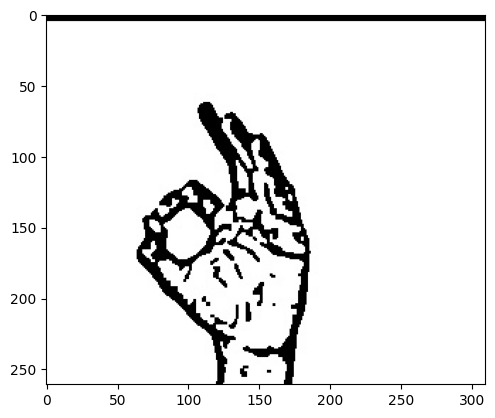

In [ ]:
raw_images = ImageFolder(data_dir, tt.ToTensor())
image, label = raw_images[0]
print("Dimension:", image.shape)
plt.imshow(image.permute(1, 2, 0))

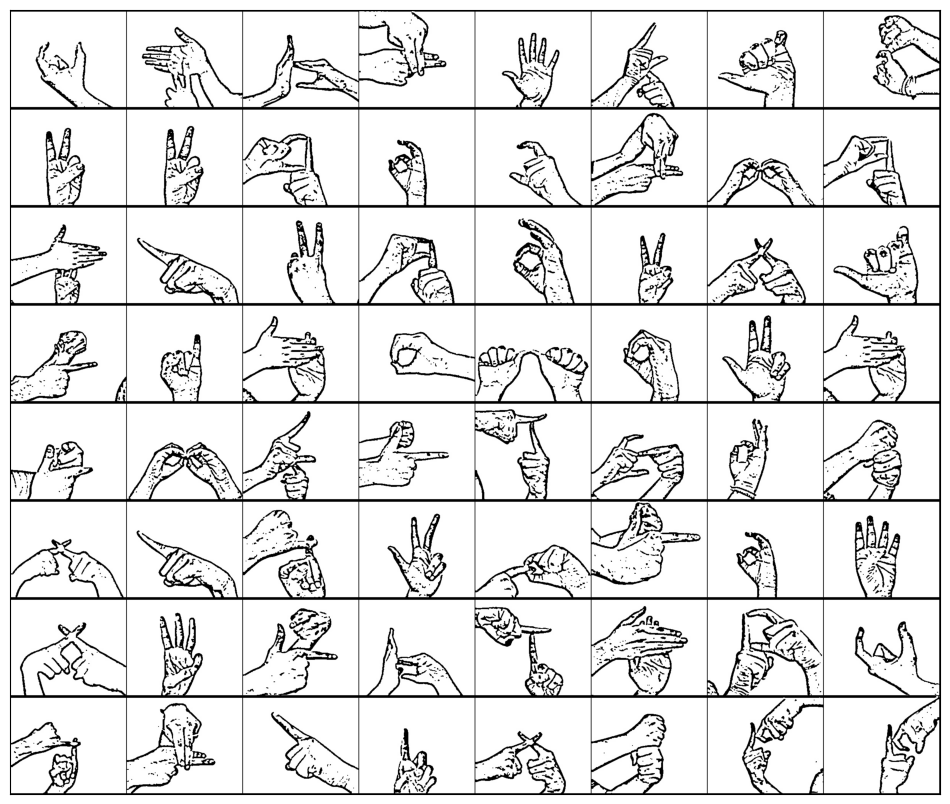

In [ ]:
# Let's create a dataloader for raw images
raw_dl = DataLoader(raw_images, 400, shuffle=True, num_workers=2, pin_memory=True)
show_batch(raw_dl)

In [ ]:
# Data transforms (normalization & data augmentation)

#stats = (stats_avgs, stats_stds)
train_tfms = tt.Compose([ tt.ToTensor() , tt.Resize(size = (128,128))])

valid_tfms = tt.Compose([tt.ToTensor(),tt.Resize(size = (128,128))])

In [ ]:
train_data = ImageFolder(data_dir, transform=train_tfms)
valid_data = ImageFolder(data_dir, transform=valid_tfms)
test_data = ImageFolder(data_dir, transform=valid_tfms)
img,label=train_data[0]
img.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 128, 128])

In [ ]:
num_train = len(train_data)
indices = list(range(num_train))
# We'll fix the random state to avoid change in the creation of train and valid data.
np.random.seed(42)
np.random.shuffle(indices)
# Let's take 15% of the train data as validation and 10% as test
valid_size = 0.15
test_size = 0.10
val_split = int(np.floor(valid_size * num_train))
test_split = int(np.floor(test_size * num_train))
valid_idx, test_idx, train_idx = indices[:val_split], indices[val_split:val_split+test_split], indices[val_split+test_split:]

In [ ]:
batch_size = 100

In [ ]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
# test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=2, pin_memory=True)
valid_dl = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=2, pin_memory=True)
# test_dl = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
#     sampler=test_sampler, num_workers=2, pin_memory=True)

In [ ]:

def show_batch(dl, denorm=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

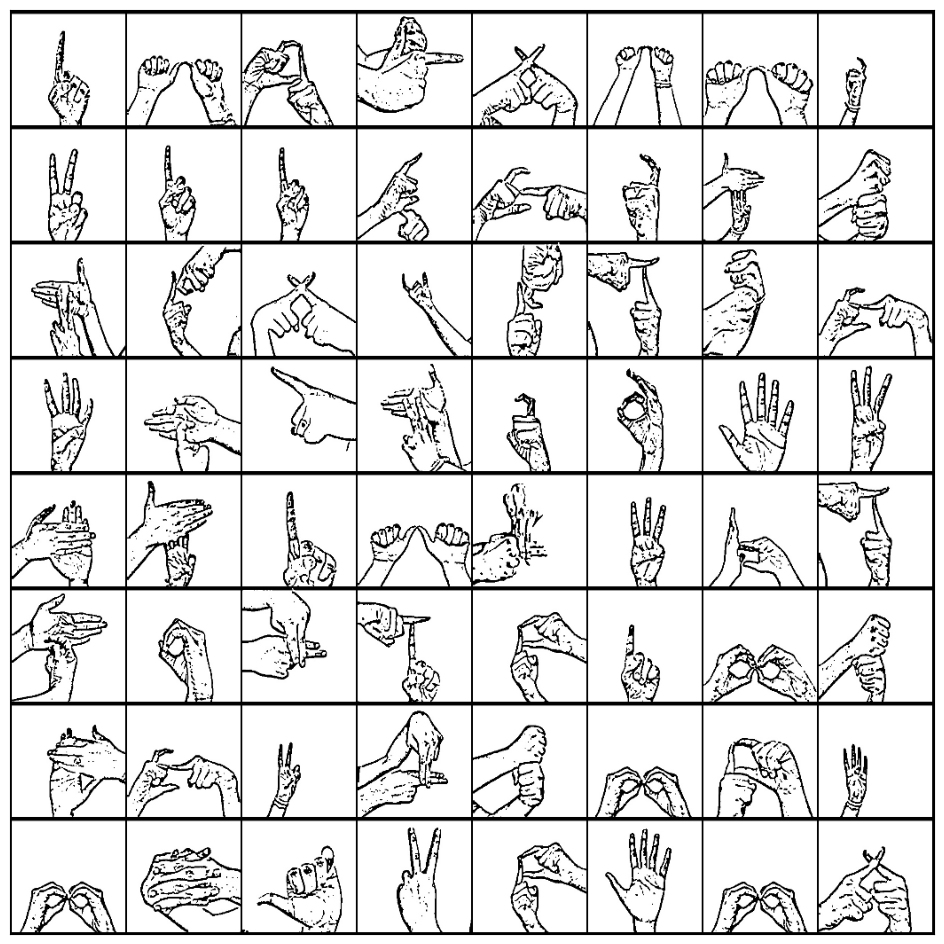

In [ ]:
# Normalized and Augmented Image
show_batch(train_dl)

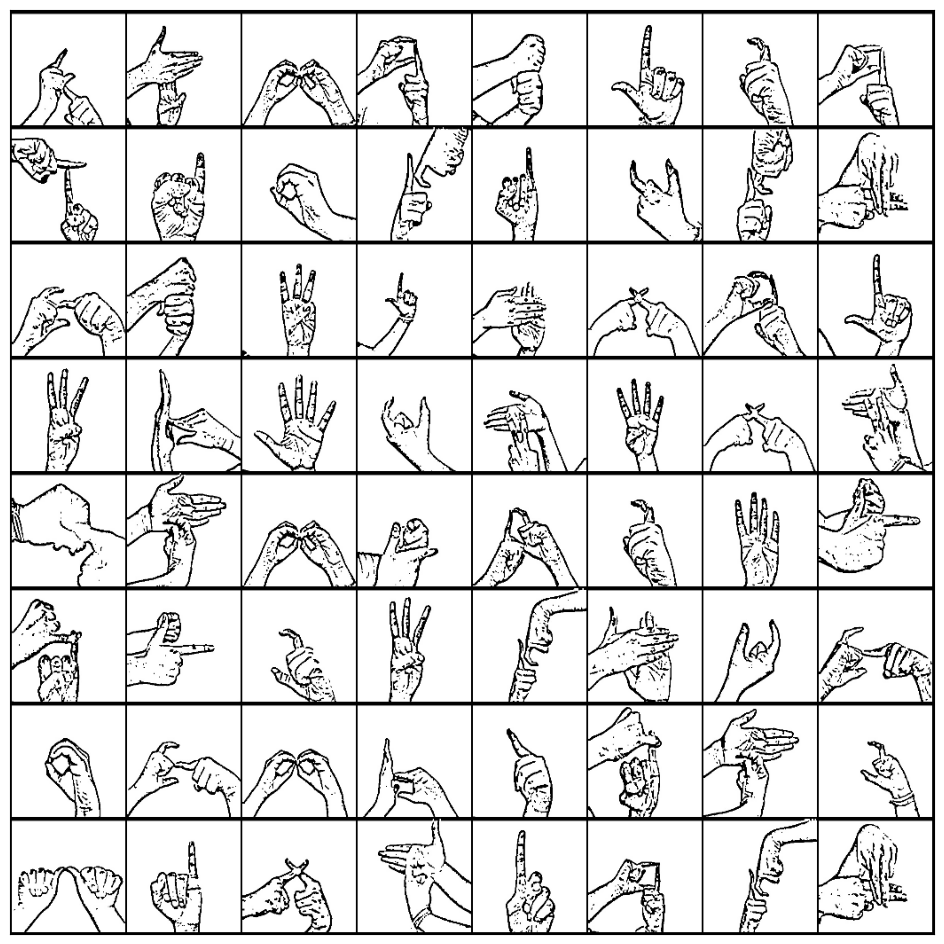

In [ ]:
show_batch(valid_dl)

In [ ]:
#for computing check
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

#for dataloader
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#main class
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

#model defenition
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64, pool=True)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.conv5 = conv_block(512, 512, pool=True)
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, target_num), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#training cycle
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
              nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader) #which will call validation_step
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 3.582632064819336, 'val_acc': 0.03891025483608246}]

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)
train_time='10:00'

Epoch [0], last_lr: 0.00265, train_loss: 2.5101, val_loss: 3.9737, val_acc: 0.0996
Epoch [1], last_lr: 0.00752, train_loss: 0.5668, val_loss: 0.5547, val_acc: 0.8316
Epoch [2], last_lr: 0.01000, train_loss: 0.1555, val_loss: 0.2063, val_acc: 0.9258
Epoch [3], last_lr: 0.00950, train_loss: 0.2994, val_loss: 0.8718, val_acc: 0.7676
Epoch [4], last_lr: 0.00812, train_loss: 0.0953, val_loss: 0.0663, val_acc: 0.9761
Epoch [5], last_lr: 0.00611, train_loss: 0.0358, val_loss: 0.3362, val_acc: 0.9468
Epoch [6], last_lr: 0.00389, train_loss: 0.0244, val_loss: 0.0038, val_acc: 1.0000
Epoch [7], last_lr: 0.00188, train_loss: 0.0075, val_loss: 0.0064, val_acc: 1.0000
Epoch [8], last_lr: 0.00050, train_loss: 0.0049, val_loss: 0.0012, val_acc: 1.0000
Epoch [9], last_lr: 0.00000, train_loss: 0.0025, val_loss: 0.0008, val_acc: 1.0000
CPU times: user 7.26 s, sys: 3.6 s, total: 10.9 s
Wall time: 1min 6s


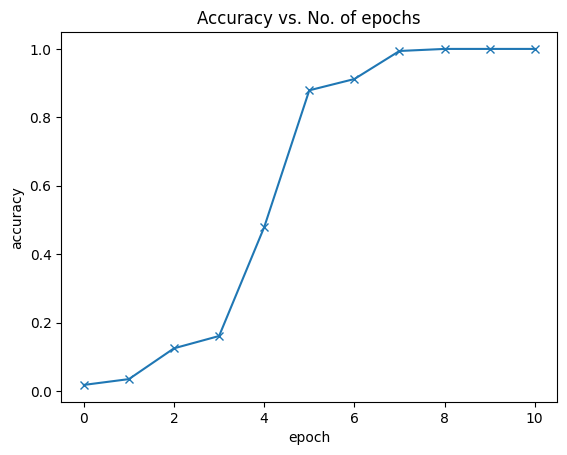

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

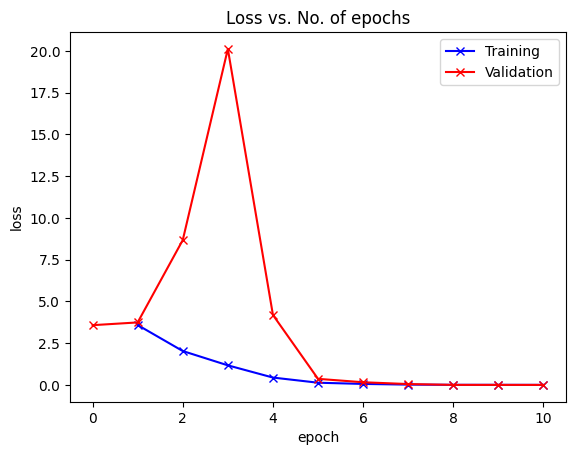

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

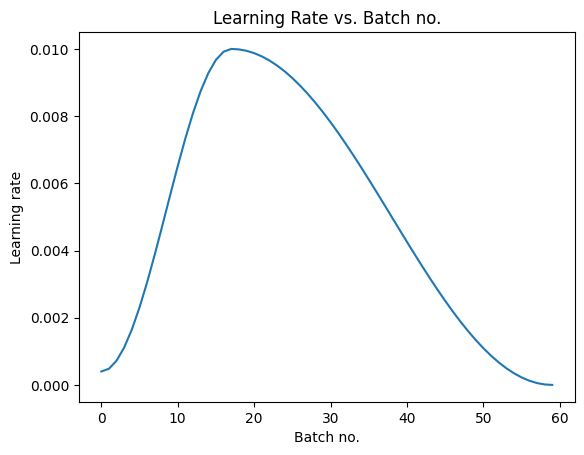

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb).squeeze(0).softmax(0)
    # Pick index with highest probability
    preds  = yb.argmax().item()
    # Retrieve the class label
    return train_data.classes[preds]

In [ ]:
correct = []
for i in test_idx:
    img, lab = test_data[i]
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    correct.append(preds[0].item() == lab)
print(f"Accuracy [Test Data]: {sum(correct) / len(test_idx) * 100} %")

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy [Test Data]: 100.0 %


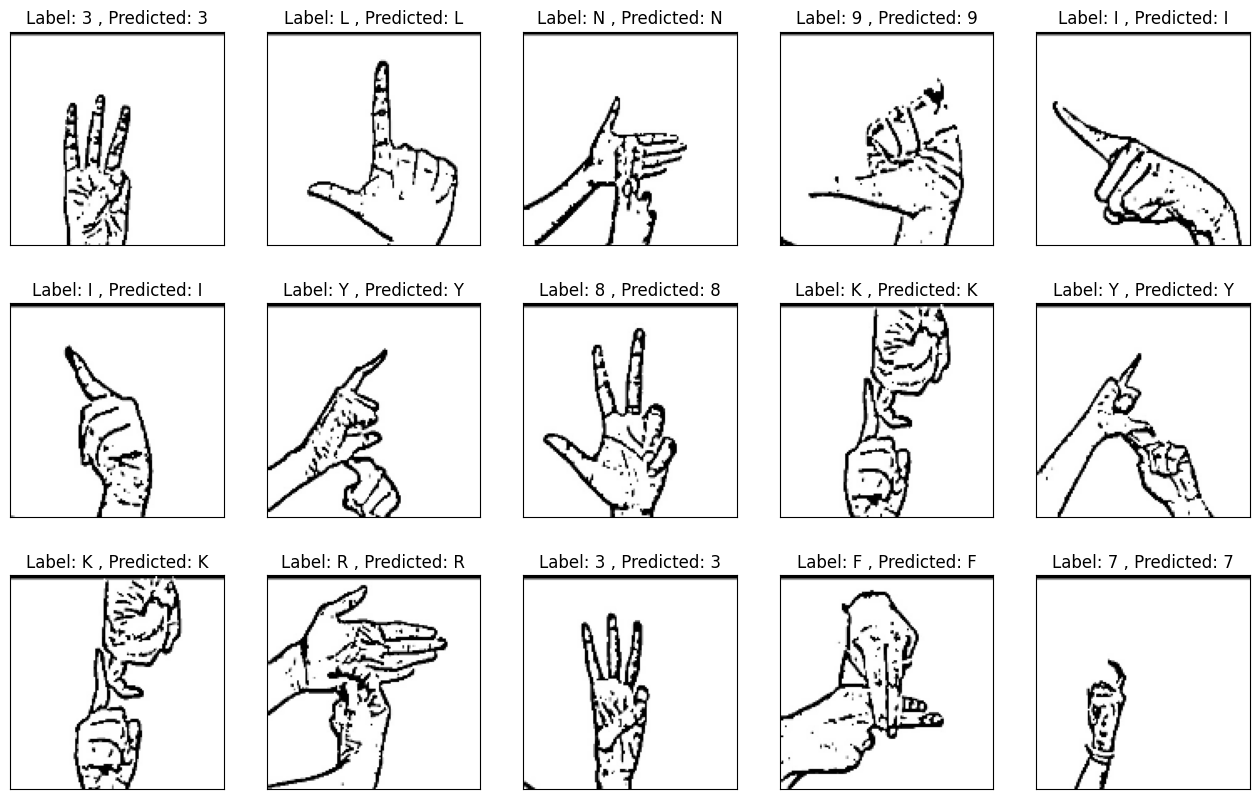

In [ ]:
n_rows, n_cols, i = 3, 5, 1
fig = plt.figure(figsize=(16,10))
for index in test_idx[:15]:
    img, label = test_data[index]
    ax = fig.add_subplot(n_rows, n_cols, i)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0).clamp(0,1))
    ax.set_title(f"Label: {test_data.classes[label]} , Predicted: {predict_image(img, model)}")
    i+=1

In [ ]:
img, label = valid_data[18561]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_data.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
import joblib
torch.save(model.state_dict(), '/content/resnet9Indian1000img.pth')
filename = 'ISN-1-custom-resnet.sav'
joblib.dump(model, filename)


['ISN-1-custom-resnet.sav']

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2

# %matplotlib inline

# # Read in the image
# image = cv2.imread("/content/indian-sign-language/Validation/Z/Z_700.jpg")

# # Change color to RGB (from BGR)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plt.imshow(image)
# # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
# pixel_vals = image.reshape((-1,3))

# # Convert to float type
# pixel_vals = np.float32(pixel_vals)
# #the below line of code defines the criteria for the algorithm to stop running,
# #which will happen is 100 iterations are run or the epsilon (which is the required accuracy)
# #becomes 85%
# criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

# # then perform k-means clustering with number of clusters defined as 3
# #also random centres are initially choosed for k-means clustering
# k = 10
# retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# # convert data into 8-bit values
# centers = np.uint8(centers)
# segmented_data = centers[labels.flatten()]

# # reshape data into the original image dimensions
# segmented_image = segmented_data.reshape((image.shape))

# plt.imshow(segmented_image)

torch.Size([3, 128, 128])
 Predicted: F
 Predicted: F


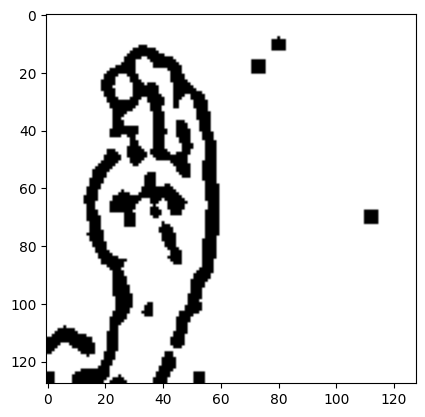

In [ ]:
minValue=70
mp_drawing = mp.solutions.drawing_utils
mp_selfie_segmentation = mp.solutions.selfie_segmentation
IMAGE_FILES = ["/content/temp.jpg"]
for idx, file in enumerate(IMAGE_FILES):
  img=cv2.imread(file)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray,(5,5),2)
  th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
  ret, res = cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  res= cv2.cvtColor(res, cv2.COLOR_GRAY2BGR)
transform = tt.Compose([tt.ToTensor(),tt.Resize(size = (128,128))])
img= transform(res)


#loading and predicting the sign
model=ResNet9(3,28)
model = to_device(ResNet9(3, target_num), device)
model.load_state_dict(torch.load("/content/drive/MyDrive/ISN-3-custom-resnet.pth",map_location=torch.device('cpu')))
model.eval()
plt.imshow(img.permute(1,2,0))
print(img.shape)
print(' Predicted:', predict_image(img, model))


# Read the image
image = Image.open(IMAGE_FILES[0])
transform = tt.Compose([tt.ToTensor(),tt.Resize(size = (128,128))])
img= transform(image)


#loading and predicting the sign
model=ResNet9(3,28)
model = to_device(ResNet9(3, target_num), device)
model.load_state_dict(torch.load("/content/drive/MyDrive/ISN-3-custom-resnet.pth",map_location=torch.device('cpu')))
model.eval()
print(' Predicted:', predict_image(img, model))